### Pathology Image Propagation with PAM

#### Overview

This tutorial shows how to use **the pre-trained PAM** for **pathology image segmentation** without fine-tuning. We use a sample from the **NeurIPS-2022-Cell-Seg (arXiv:2308.05864)** dataset (https://link.zhihu.com/?target=https%3A//neurips22-cellseg.grand-challenge.org/dataset/) where pathology images are stored as `.bmp` files (`tutorials/datasets/NeurIPS-2022-Cell-Seg_subset/images/`). Each image ships with a sparse **prompt mask** (`tutorials/datasets/NeurIPS-2022-Cell-Seg_subset/prompts/`) that contains manual annotations for only a few cell instances.

Key ideas showcased here:

- **Few-shot propagation**: A small number of manually annotated cell instances (prompts) guide predictions across the entire pathology image, enabling PAM to segment all similar cells without any fine-tuning.
- **Sliding window inference**: For large pathology images (or WSI - Whole Slide Images), we use a sliding window approach to process the entire image efficiently.
- **Instance segmentation**: The pipeline automatically identifies and segments individual cell instances throughout the image.
- **Reusable workflow**: Simply provide your pathology image along with prompt masks marking a few target cells. PAM automatically propagates this information throughout the entire image and returns dense instance segmentation.

> **Scope**: The goal of this tutorial is to illustrate PAM, which is proposed for radiological volumetric segmentation, can also be served as a pathology annotation assistant, achieving "minimal manual annotation - dense object segmentation". You should manually verify the propagated masks for clinical use.


#### 1. Dataset Layout and Goal

We assume the NeurIPS-2022-Cell-Seg subset is organised as follows (feel free to adapt paths to your project):

```
tutorials/datasets/NeurIPS-2022-Cell-Seg_subset/
├── images/            # e.g., cell_00001.bmp (pathology images)
├── prompts/           # matching prompt masks; e.g., cell_00001.png (sparse annotations)
└── results/           # created automatically to store propagated masks
```

Each `.png` file in `prompts/` mirrors the filename in `images/` (with different extension). The prompt masks contain foreground pixels (value > 0) marking a few example cells. PAM consumes this sparse input and extrapolates the segmentation to similar cells across the entire image.

Workflow summary:

1. Load the pathology image and its prompt mask.
2. Extract guiding instances from the prompt mask.
3. Use sliding window to process the entire image with PAM.
4. Merge predictions from overlapping windows.
5. Perform instance segmentation to identify individual cells.
6. Visualize and save the results.


In [7]:
import os
import sys
import numpy as np
import torch
import torch.nn.functional as F
from pathlib import Path
from tqdm import tqdm
from PIL import Image, ImageOps
from scipy import ndimage
from skimage import measure, morphology, draw
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Add repo root to path so we can import PAM
sys.path.insert(0, "..")
from model.PAM import PAM

# -----------------------------------------------------------------------------
# Global configuration
# -----------------------------------------------------------------------------
DATASET_DIR = "datasets/NeurIPS-2022-Cell-Seg_subset"
CHECKPOINT_PATH = "./checkpoints/propmask.pth"  # Update this path to your checkpoint
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PAM_IMG_SIZE = 224
PAM_INFER_BATCH_SIZE = 8

print(f"Using device: {DEVICE}")
assert os.path.isdir(DATASET_DIR), f"Dataset directory '{DATASET_DIR}' not found"


Using device: cpu


In [8]:
# -----------------------------------------------------------------------------
# Utility functions
# -----------------------------------------------------------------------------

def normalize_torch(img: torch.Tensor, img_min: torch.Tensor, img_max: torch.Tensor, device: torch.device) -> torch.Tensor:
    """Normalize image tensor to [0, 1] range using dynamic min/max"""
    eps = 1e-8
    img_clipped = torch.clamp(img, img_min, img_max)
    img_normalized = (img_clipped - img_min) / (img_max - img_min + eps)
    return img_normalized

def compute_dynamic_internal_torch(support_img: torch.Tensor, support_mask: torch.Tensor, device) -> tuple:
    """Compute dynamic normalization range based on foreground pixels"""
    if support_img.ndim == 4:
        img2d = support_img[0, 0]
    elif support_img.ndim == 3:
        img2d = support_img[0]
    elif support_img.ndim == 2:
        img2d = support_img
    else:
        raise ValueError("support_img must be (h,w) or (1,1,h,w)")
    if support_mask.ndim == 4:
        m2d = support_mask[0, 0] > 0
    elif support_mask.ndim == 3:
        m2d = support_mask[0] > 0
    elif support_mask.ndim == 2:
        m2d = support_mask > 0
    else:
        raise ValueError("support_mask must be (h,w) or (1,1,h,w)")
    vals = img2d[m2d]
    if vals.numel() == 0:
        vals = img2d.reshape(-1)
    q = torch.quantile(vals, torch.tensor([0.05, 0.95], device=device))
    img_min = q[0]
    img_max = q[1]
    return img_min, img_max

def pad_and_resize(pil_img: Image.Image, target_size: int, is_mask: bool = False) -> Image.Image:
    """Pad image to square and resize to target_size"""
    w, h = pil_img.size
    max_side = max(w, h)
    
    pad_left = (max_side - w) // 2
    pad_right = max_side - w - pad_left
    pad_top = (max_side - h) // 2
    pad_bottom = max_side - h - pad_top
    
    fill = 0
    padded = ImageOps.expand(pil_img, border=(pad_left, pad_top, pad_right, pad_bottom), fill=fill)
    
    resample = Image.NEAREST if is_mask else Image.BILINEAR
    resized = padded.resize((target_size, target_size), resample=resample)
    return resized

def instance_segmentation(mask):
    """Convert binary mask to instance mask using connected components"""
    unique_values = np.unique(mask)
    if len(unique_values) > 2:  # Already has multiple instances
        return mask
    else:
        binary_mask = (mask > 0).astype(np.uint8)
        labeled_mask = measure.label(binary_mask, connectivity=2)
        return labeled_mask

def extract_instance_crops(image, mask, instance_id, padding_ratio=0.2, target_size=224):
    """Extract a square crop around a single instance"""
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = image
    
    instance_mask = (mask == instance_id)
    if not instance_mask.any():
        return None, None
    
    coords = np.where(instance_mask)
    min_y, max_y = coords[0].min(), coords[0].max()
    min_x, max_x = coords[1].min(), coords[1].max()
    
    center_y = (min_y + max_y) // 2
    center_x = (min_x + max_x) // 2
    h = max_y - min_y + 1
    w = max_x - min_x + 1
    
    padding_h = int(h * padding_ratio)
    padding_w = int(w * padding_ratio)
    
    side_length = max(h + 2 * padding_h, w + 2 * padding_w)
    
    half_side = side_length // 2
    crop_min_y = max(0, center_y - half_side)
    crop_max_y = min(img_array.shape[0], center_y + half_side)
    crop_min_x = max(0, center_x - half_side)
    crop_max_x = min(img_array.shape[1], center_x + half_side)
    
    cropped_img = img_array[crop_min_y:crop_max_y, crop_min_x:crop_max_x]
    cropped_mask = mask[crop_min_y:crop_max_y, crop_min_x:crop_max_x]
    cropped_mask = (cropped_mask == instance_id).astype(np.uint8)
    
    if len(cropped_img.shape) == 3:
        cropped_img_pil = Image.fromarray(cropped_img)
    else:
        cropped_img_pil = Image.fromarray(cropped_img).convert('L')
    cropped_mask_pil = Image.fromarray(cropped_mask * 255).convert('L')
    
    cropped_img_pil = pad_and_resize(cropped_img_pil, target_size, is_mask=False)
    cropped_mask_pil = pad_and_resize(cropped_mask_pil, target_size, is_mask=True)
    
    return cropped_img_pil, cropped_mask_pil

def sliding_window(image, window_size, stride, target_size=None):
    """Sliding window over image, returning crops and positions"""
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = image
    
    if target_size is None:
        target_size = window_size
    
    h, w = img_array.shape[:2]
    crops = []
    positions = []
    
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            y_min = y
            y_max = min(y + window_size, h)
            x_min = x
            x_max = min(x + window_size, w)
            
            crop = img_array[y_min:y_max, x_min:x_max]
            
            if len(crop.shape) == 3:
                crop_pil = Image.fromarray(crop)
            else:
                crop_pil = Image.fromarray(crop).convert('L')
            
            crop_pil = pad_and_resize(crop_pil, target_size, is_mask=False)
            
            crops.append(crop_pil)
            positions.append((y_min, y_max, x_min, x_max))
    
    return crops, positions

print("Utility functions defined")


Utility functions defined


In [10]:
# -----------------------------------------------------------------------------
# Model loading
# -----------------------------------------------------------------------------

def load_checkpoint(model, checkpoint_path, checkpoint_prefix="module.", printer=print):
    """Load model checkpoint"""
    key_num = 0
    state_dict = torch.load(checkpoint_path, map_location=DEVICE)
    if "model_state_dict" in state_dict:
        state_dict = state_dict["model_state_dict"]
    model_state_dict = model.state_dict()
    for key, value in state_dict.items():
        tmp_key = key.replace(checkpoint_prefix, "")
        if tmp_key in model_state_dict:
            model_state_dict[tmp_key] = value
            key_num += 1
    msg = model.load_state_dict(model_state_dict, strict=False)
    printer(f"Loaded checkpoint ({key_num}/{len(model_state_dict)} params): {msg}")
    return model

pam_model = PAM(
    conv_dim=2,  # 2D convolutions
    input_channels=1,
    n_stages=6,
    max_channels=512,
    num_classes=2,
    deep_supervision=True,
    n_attn_stage=4,
    from_scratch_ratio=0.0,
)

assert os.path.exists(CHECKPOINT_PATH), f"Checkpoint not found at {CHECKPOINT_PATH}. Please update CHECKPOINT_PATH."
pam_model = load_checkpoint(pam_model, CHECKPOINT_PATH)


pam_model = pam_model.to(DEVICE)
pam_model.eval()
print("PAM model ready for pathology segmentation")


Loaded checkpoint (408/408 params): <All keys matched successfully>
PAM model ready for pathology segmentation


#### 2. Process Guiding Instances from Prompt Mask

First, we extract individual cell instances from the prompt mask. Each instance will serve as a guiding example for PAM to find similar cells in the rest of the image.


In [11]:
def process_guiding_instances(image_path, mask_path, padding_ratio=0.2):
    """Process guiding instances: load mask, instance segmentation, extract crops"""
    # Load image
    image = Image.open(image_path)
    if image.mode == 'RGB':
        image = image.convert('L')  # Convert to grayscale
    img_array = np.array(image)
    
    # Load mask
    mask = np.array(Image.open(mask_path).convert('L'))
    mask = (mask > 127).astype(np.uint8)  # Binarize
    
    # Instance segmentation
    instance_mask = instance_segmentation(mask)
    unique_instances = np.unique(instance_mask)
    unique_instances = unique_instances[unique_instances > 0]  # Exclude background
    
    print(f"Found {len(unique_instances)} instances in prompt mask")
    
    # Extract crops for each instance
    guiding_images = []
    guiding_masks = []
    instance_sizes = []
    
    for idx, instance_id in enumerate(unique_instances):
        cropped_img, cropped_mask = extract_instance_crops(
            image, instance_mask, instance_id, padding_ratio, PAM_IMG_SIZE
        )
        
        if cropped_img is None:
            continue
        
        guiding_images.append(cropped_img)
        guiding_masks.append(cropped_mask)
        
        # Record instance size
        instance_region = (instance_mask == instance_id)
        coords = np.where(instance_region)
        h = coords[0].max() - coords[0].min() + 1
        w = coords[1].max() - coords[1].min() + 1
        instance_sizes.append((w, h))
        
        print(f"  Instance {idx}: size {w}x{h}")
    
    return guiding_images, guiding_masks, instance_sizes

# Select a case
CASE_ID = "cell_00001"
image_path = os.path.join(DATASET_DIR, "images", f"{CASE_ID}.bmp")
mask_path = os.path.join(DATASET_DIR, "prompts", f"{CASE_ID}.png")

print(f"Processing case: {CASE_ID}")
guiding_images, guiding_masks, instance_sizes = process_guiding_instances(image_path, mask_path)


Processing case: cell_00001
Found 1 instances in prompt mask
  Instance 0: size 347x344


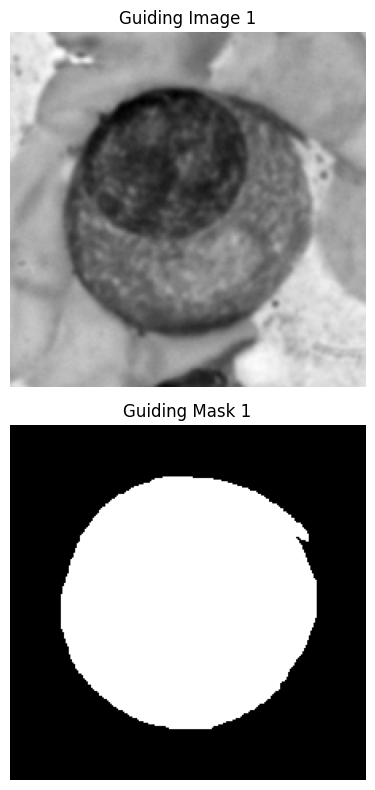

In [ ]:
# Visualize guiding instances
n_instances = len(guiding_images)
fig, axes = plt.subplots(2, n_instances, figsize=(4*n_instances, 8))
if n_instances == 1:
    axes = axes.reshape(2, 1)

for idx in range(n_instances):
    axes[0, idx].imshow(guiding_images[idx], cmap='gray')
    axes[0, idx].set_title(f'Guiding Image {idx+1}')
    axes[0, idx].axis('off')
    
    axes[1, idx].imshow(guiding_masks[idx], cmap='gray')
    axes[1, idx].set_title(f'Guiding Mask {idx+1}')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()
plt.close()


#### 3. Sliding Window Inference

Now we use sliding window to process the entire pathology image. For each window, we use the guiding instances to predict cell segmentation.


In [13]:
def determine_window_size(instance_sizes, min_size=224, max_size=512):
    """Determine sliding window size based on instance sizes"""
    if not instance_sizes:
        return min_size
    
    widths = [s[0] for s in instance_sizes]
    heights = [s[1] for s in instance_sizes]
    max_dim = max(max(widths), max(heights))
    
    window_size = int(max_dim * 1.5)  # 1.5x padding
    window_size = max(min_size, min(window_size, max_size))
    window_size = ((window_size + PAM_IMG_SIZE - 1) // PAM_IMG_SIZE) * PAM_IMG_SIZE
    
    print(f"Determined window size: {window_size} (max instance size: {max_dim})")
    return window_size

def stitch_predictions(predictions, probabilities, positions, original_shape, window_size):
    """Stitch sliding window predictions back to original image size"""
    h, w = original_shape
    
    pred_sum = np.zeros((h, w), dtype=np.float32)
    prob_sum = np.zeros((h, w), dtype=np.float32)
    count = np.zeros((h, w), dtype=np.float32)
    
    for pred, prob, (y_min, y_max, x_min, x_max) in zip(predictions, probabilities, positions):
        pred_resized = np.array(Image.fromarray(pred.astype(np.uint8) * 255).resize(
            (x_max - x_min, y_max - y_min), Image.NEAREST)) > 127
        prob_resized = np.array(Image.fromarray((prob * 255).astype(np.uint8)).resize(
            (x_max - x_min, y_max - y_min), Image.BILINEAR)) / 255.0
        
        pred_sum[y_min:y_max, x_min:x_max] += pred_resized.astype(np.float32)
        prob_sum[y_min:y_max, x_min:x_max] += prob_resized
        count[y_min:y_max, x_min:x_max] += 1.0
    
    count = np.maximum(count, 1.0)
    final_pred = (pred_sum / count >= 0.1).astype(np.uint8)
    final_prob = prob_sum / count
    
    return final_pred, final_prob

# Determine window size
window_size = determine_window_size(instance_sizes)
stride = window_size // 2  # 50% overlap


Determined window size: 672 (max instance size: 347)


In [ ]:
def sliding_window_inference(image_path, guiding_image, guiding_mask, window_size, stride):
    """Perform sliding window inference on entire image"""
    # Load image
    image = Image.open(image_path)
    if image.mode == 'RGB':
        image = image.convert('L')
    img_array = np.array(image)
    h, w = img_array.shape[:2]
    
    print(f"Image size: {h}x{w}, Window size: {window_size}, Stride: {stride}")
    
    # Prepare guiding data - convert to tensor and normalize
    guiding_img_array = np.array(guiding_image)
    guiding_mask_array = np.array(guiding_mask) / 255.0  # Normalize to [0, 1]
    
    guiding_x = torch.from_numpy(guiding_img_array).float().to(DEVICE)
    guiding_y = torch.from_numpy(guiding_mask_array).float().to(DEVICE)
    
    # Compute normalization parameters
    img_min, img_max = compute_dynamic_internal_torch(guiding_x, guiding_y, DEVICE)
    
    # Normalize guiding image
    guiding_x = normalize_torch(guiding_x, img_min, img_max, DEVICE)
    guiding_x = guiding_x.unsqueeze(dim=0).unsqueeze(dim=0)  # (1, 1, H, W)
    guiding_prp = guiding_y.unsqueeze(dim=0).unsqueeze(dim=0)  # (1, 1, H, W)
    ### TODO: default batch_size=1, meaning only one guiding instance used per propagation,
    ###       if you want to use multiple guiding instances, you need to change the batch_size and the way of aggregating predictions across multiple prompts

    # Sliding window
    crops, positions = sliding_window(image, window_size, stride, target_size=PAM_IMG_SIZE)
    print(f"Total {len(crops)} windows to process")
    
    predictions = []
    probabilities = []
    
    for i in tqdm(range(0, len(crops), PAM_INFER_BATCH_SIZE)):
        # Prepare query images
        batch_crops = crops[i:i+PAM_INFER_BATCH_SIZE]
        query_imgs = []
        for j, crop in enumerate(batch_crops):
            crop_array = np.array(crop)
            crop_tensor = torch.from_numpy(crop_array).float().to(DEVICE)
            crop_normalized = normalize_torch(crop_tensor, img_min, img_max, DEVICE)
            query_imgs.append(crop_normalized)
        
        query_xs = torch.stack(query_imgs, dim=0)  # (N, H, W)
        query_xs = query_xs.unsqueeze(dim=0).unsqueeze(dim=2)  # (1, N, 1, H, W)
        assert query_xs.shape[0] == 1, "only one guiding instance is supported for now"
        
        batch = {
            "guiding_x": guiding_x,
            "guiding_prp": guiding_prp.squeeze(dim=1),  # (1, H, W)
            "adjacent_x": query_xs,  # (1, N, H, W)
        }
        
        with torch.no_grad():
            pred_dict = pam_model(batch)
        
        # Process predictions from deep supervision
        preds = [pred_dict["predictions"][0]]
        pred_size = preds[0].size()[-2:]
        for pred in pred_dict["predictions"][1:]:
            preds.append(F.interpolate(pred, size=pred_size, mode="bilinear", align_corners=True))
        preds = torch.mean(torch.stack(preds, dim=0), dim=0)  # (B, C, Nadj, H, W)
        
        # Get probabilities and labels
        probs = torch.softmax(preds, dim=1)[:, 1, ...]  # (Nadj, H, W)
        pred_labels = torch.argmax(preds, dim=1)  # (Nadj, H, W)
        
        predictions.append(pred_labels.cpu().numpy())
        probabilities.append(probs.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    probabilities = np.concatenate(probabilities, axis=0)
    
    # Stitch predictions
    final_pred, final_prob = stitch_predictions(predictions, probabilities, positions, (h, w), window_size)
    
    return final_pred, final_prob

# Run inference for all guiding instances and merge results
print("Running sliding window inference for all guiding instances...")
all_predictions = []
all_probabilities = []

for idx, (guiding_img, guiding_mask) in enumerate(zip(guiding_images, guiding_masks)):
    print(f"\nProcessing guiding instance {idx+1}/{len(guiding_images)}...")
    pred, prob = sliding_window_inference(
        image_path, guiding_img, guiding_mask, window_size, stride
    )
    all_predictions.append(pred)
    all_probabilities.append(prob)

# Merge predictions from multiple guiding instances
print("\nMerging predictions from all guiding instances...")
final_pred = np.zeros_like(all_predictions[0])
final_prob = np.zeros_like(all_probabilities[0])

for pred, prob in zip(all_predictions, all_probabilities):
    final_pred = np.maximum(final_pred, pred)
    final_prob = np.maximum(final_prob, prob)

print("Inference completed!")


Running sliding window inference for all guiding instances...

Processing guiding instance 1/1...
Image size: 1920x2560, Window size: 672, Stride: 336
Total 48 windows to process


100%|██████████| 6/6 [00:23<00:00,  3.86s/it]


Merging predictions from all guiding instances...
Inference completed!


#### 4. Instance Segmentation

After obtaining the binary prediction mask, we perform instance segmentation to identify individual cells.


In [30]:
def perform_instance_segmentation(binary_mask, erosion_size=3, dilation_size=3, min_area=100, max_area=150000):
    """Perform instance segmentation with morphological operations"""
    # Erosion to remove small noise and connections
    erosion_kernel = morphology.disk(erosion_size)
    eroded_mask = morphology.binary_erosion(binary_mask, erosion_kernel)
    
    # Connected components to find instances
    labeled_mask = measure.label(eroded_mask, connectivity=2)
    unique_instances = np.unique(labeled_mask)
    unique_instances = unique_instances[unique_instances > 0]
    num_instances = len(unique_instances)
    print(f"Detected {num_instances} instances after erosion")
    
    # Dilation to restore instance size
    dilation_kernel = morphology.disk(dilation_size)
    instance_mask = np.zeros_like(labeled_mask, dtype=np.uint16)
    
    for inst_id in unique_instances:
        instance_region = (labeled_mask == inst_id)
        dilated_instance = morphology.binary_dilation(instance_region, dilation_kernel)
        area = dilated_instance.sum()
        if area >= min_area and area <= max_area:
            instance_mask[dilated_instance] = inst_id
    
    # Renumber instances
    unique_instances = np.unique(instance_mask)
    unique_instances = unique_instances[unique_instances > 0]
    remap = {old: i+1 for i, old in enumerate(unique_instances)}
    final_instance_mask = np.zeros_like(instance_mask)
    for old, new in remap.items():
        final_instance_mask[instance_mask == old] = new
    
    print(f"Final instance count: {len(unique_instances)} (after filtering)")
    return final_instance_mask

instance_mask = perform_instance_segmentation(final_pred)


Detected 9 instances after erosion
Final instance count: 9 (after filtering)


#### 5. Visualization

Finally, we visualize the results by overlaying instance contours on the original image.


In [35]:
def visualize_instances_on_image(image_path, instance_mask, edge_width=3, color_mode="per-instance"):
    """Visualize instance contours overlaid on original image"""
    orig_img = Image.open(image_path)
    orig = np.array(orig_img.convert('RGB'))
    h, w = orig.shape[:2]
    
    unique_instances = np.unique(instance_mask)
    unique_instances = unique_instances[unique_instances > 0]
    
    if color_mode == "per-instance":
        colormap = cm.get_cmap('tab20', max(1, len(unique_instances)))
        id2color = {
            inst_id: (np.array(colormap(i % colormap.N)[:3]) * 255).astype(np.uint8)
            for i, inst_id in enumerate(unique_instances)
        }
    else:
        id2color = {inst_id: np.array([255, 0, 0], dtype=np.uint8) for inst_id in unique_instances}
    
    selem = morphology.disk(max(1, edge_width // 2))
    viz = orig.copy()
    
    for inst_id in unique_instances:
        inst = (instance_mask == inst_id)
        if not inst.any():
            continue
        
        edge_mask = np.zeros((h, w), dtype=bool)
        contours = measure.find_contours(inst.astype(float), 0.5)
        for contour in contours:
            contour_int = np.round(contour).astype(int)
            contour_int[:, 0] = np.clip(contour_int[:, 0], 0, h - 1)
            contour_int[:, 1] = np.clip(contour_int[:, 1], 0, w - 1)
            if len(contour_int) > 2:
                rr, cc = draw.polygon_perimeter(contour_int[:, 0], contour_int[:, 1], shape=(h, w))
                edge_mask[rr, cc] = True
        
        if edge_width > 1:
            edge_mask = morphology.binary_dilation(edge_mask, selem)
        
        viz[edge_mask] = id2color[inst_id]
    
    return viz

# Create visualization
viz_image = visualize_instances_on_image(image_path, instance_mask, edge_width=8, color_mode="fixed")

# Save results
output_dir = os.path.join(DATASET_DIR, "results")
os.makedirs(output_dir, exist_ok=True)

Image.fromarray((final_pred * 255).astype(np.uint8)).save(os.path.join(output_dir, f"{CASE_ID}_pred_mask.png"))
Image.fromarray((final_prob * 255).astype(np.uint8)).save(os.path.join(output_dir, f"{CASE_ID}_prob_map.png"))
Image.fromarray(instance_mask.astype(np.uint16)).save(os.path.join(output_dir, f"{CASE_ID}_instance_mask.png"))
Image.fromarray(viz_image).save(os.path.join(output_dir, f"{CASE_ID}_visualization.png"))

print(f"Results saved to {output_dir}/")


Results saved to datasets/NeurIPS-2022-Cell-Seg_subset/results/


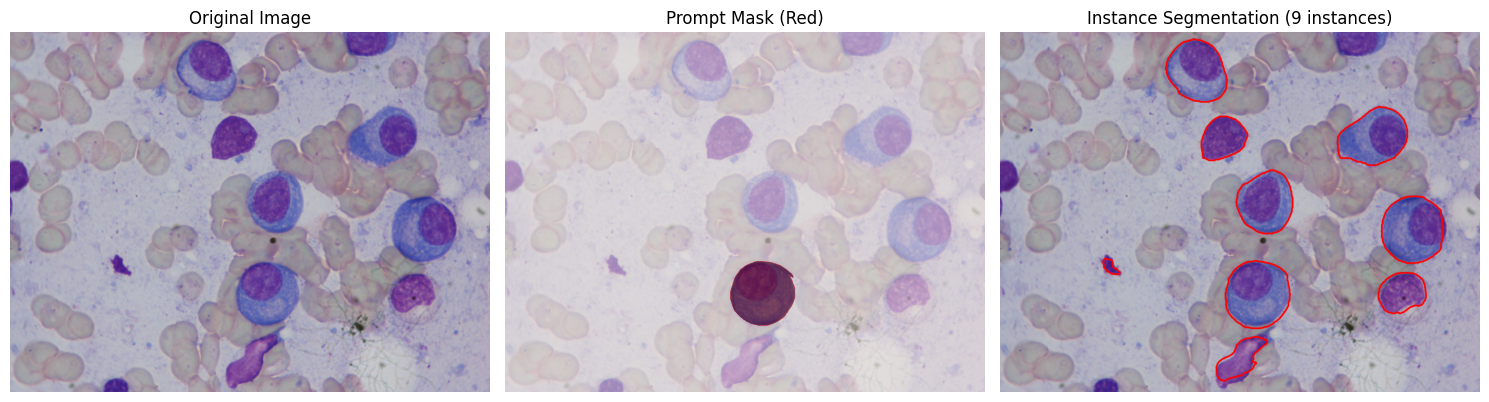

In [36]:
# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
orig_img = Image.open(image_path)
axes[0].imshow(orig_img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Prompt mask overlay
prompt_mask = np.array(Image.open(mask_path).convert('L'))
axes[1].imshow(orig_img, cmap='gray')
axes[1].imshow(prompt_mask, alpha=0.5, cmap='Reds')
axes[1].set_title('Prompt Mask (Red)')
axes[1].axis('off')

# Instance segmentation visualization
axes[2].imshow(viz_image)
axes[2].set_title(f'Instance Segmentation ({len(np.unique(instance_mask))-1} instances)')
axes[2].axis('off')

plt.tight_layout()
plt.show()
plt.close()

#### Tips and Future Directions

This tutorial demonstrates how the **PAM model** (originally proposed for general-purpose 3D medical image segmentation) can be applied to pathology image segmentation **without any retraining or fine-tuning**. By leveraging PAM's powerful cross-region semantic understanding and consistency measurement capabilities, it can accurately identify and segment cells in pathology images.

However, this example represents only a simple demonstration, and there is significant room for improvement:

1. **Sliding window integration**: More sophisticated strategies for sliding window overlap and integration/voting mechanisms could improve segmentation quality and reduce boundary artifacts.

2. **Multiple guiding instances**: Using more diverse guiding instances can help the model better capture the variability in cell appearance and improve generalization.

3. **Multi-scale sliding windows**: Implementing multi-scale sliding windows can address the challenge of objects with varying sizes, ensuring both small and large cells are properly segmented.

4. **Domain-specific fine-tuning**: With a small amount of pathology-specific data, fine-tuning the PAM model could create a domain-adapted model that performs even better on pathology images while maintaining its generalizability.

These optimizations can further enhance the "minimal manual annotation - dense object segmentation" workflow, making PAM an even more powerful tool for pathology image analysis.
